# Using a Modflow DRN model as a stressmodel in Pastas

In [1]:
import os

import flopy
import pandas as pd
import pastas as ps

import pastas_plugins.modflow as ppmf

from pastas.timer import SolveTimer

ps.set_log_level("ERROR")

bindir = "bin"
mf6_exe = os.path.join(bindir, "mf6")
if not os.path.isfile(mf6_exe):
    if not os.path.isdir(bindir):
        os.makedirs(bindir)
    flopy.utils.get_modflow("bin", repo="modflow6")

%load_ext autoreload
%autoreload 2

fetched release '6.5.0' info from MODFLOW-USGS/modflow6
using previous download 'C:\Users\Ruben\Downloads\modflow6-6.5.0-win64.zip' (use 'force=True' to re-download)
extracting 4 files to 'C:\Users\Ruben\Documents\GitHub\pastas-plugins\docs\examples\bin'
libmf6.dll mf5to6.exe mf6.exe    zbud6.exe
updated flopy metadata file: 'C:\Users\Ruben\AppData\Local\flopy\get_modflow.json'


In [2]:
df = pd.read_csv("data/aftopping.csv", index_col=0, parse_dates=True)
head = df["B28H1808_2"].dropna()
prec = df["Precipitation"]
evap = df["Evaporation"]

Fit report B28H1808_2             Fit Statistics
nfev    8                      EVP         93.67
nobs    1261                   R2           0.94
noise   False                  RMSE         0.08
tmin    2012-06-07 00:00:00    AICc     -6473.86
tmax    2017-02-01 00:00:00    BIC      -6453.33
freq    D                      Obj          3.69
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal     initial  vary
exp_A       400.768674  258.226873  True
exp_a        91.715057   10.000000  True
exp_f        -1.045222   -1.000000  True
constant_d   19.661340   19.880246  True


<Axes: ylabel='Head'>

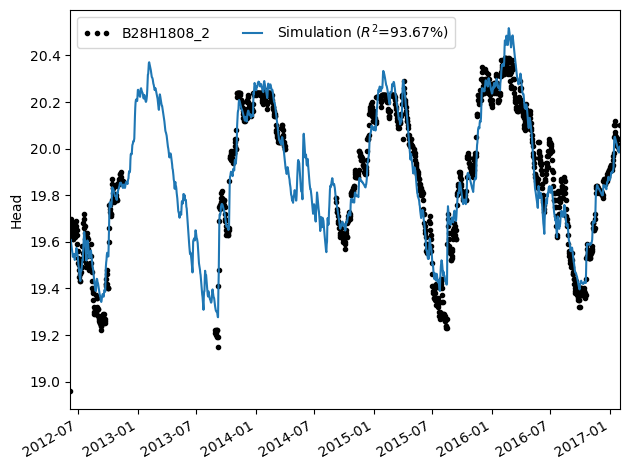

In [3]:
mlexp = ps.Model(head)
mlexp.add_stressmodel(
    ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="exp")
)
mlexp.solve()
mlexp.plot()

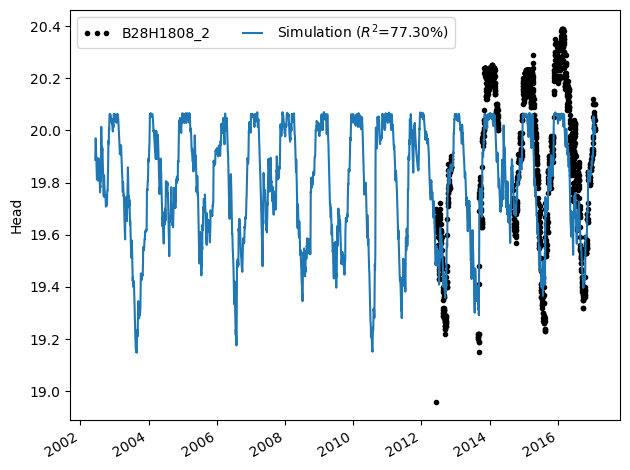

In [8]:
mldmf = ps.Model(head)

expmf = ppmf.ModflowDrn(exe_name=mf6_exe, sim_ws="mf_files/drn_gw", head=head)
expsm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=expmf, name="uzfsm")
mldmf.add_stressmodel(expsm)
mldmf.set_parameter(f"{expsm.name}_s", initial=mlexp.parameters.at["exp_a", "optimal"] / mlexp.parameters.at["exp_A", "optimal"], vary=False)
mldmf.set_parameter(f"{expsm.name}_c", initial=mlexp.parameters.at["exp_A", "optimal"], vary=False)
constant_d = mlexp.parameters.at["constant_d", "optimal"]
if "constant_d" in mldmf.parameters.index:
    mldmf.set_parameter("constant_d", initial=constant_d, vary=False)
    if expmf._head is not None:
        mldmf.del_constant()
        mldmf.set_parameter(f"{expsm.name}_d", initial=constant_d, vary=False)
mldmf.set_parameter(f"{expsm.name}_drnheight", initial=0.4, vary=False)
ax = mldmf.plot()